# MODELISATION

Here we finally build our classifier and make predictions with the XGBoost framework which can use GPU. If you prefer to use CPU, you will need to remove the argument `tree_method="gpu_hist"` when initializing the `XGBClassifier`.

In [1]:
# # UNCOMMENT IF USING COLLAB
# !pip install tables==3.5.1
# !pip install xgboost --upgrade

In [2]:
import pickle
import os
import sys
import time

import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

from gensim.models.doc2vec import Doc2Vec
from gensim.models import KeyedVectors

plt.rcParams['figure.figsize'] = (10, 7)

import paths

Mounted at /content/drive


## 1. Load features

In [3]:
# Read the features datasets
X_train = pd.read_hdf(paths.STORAGE_STAGE2_PATH, key='X_train', mode='r')
X_test = pd.read_hdf(paths.STORAGE_STAGE2_PATH, key='X_test', mode='r')
X_challenge = pd.read_hdf(paths.STORAGE_STAGE2_PATH, key='X_challenge', mode='r')
# Read labels
train_target = pd.read_csv(paths.TRAIN_TARGET_PATH, header=None).to_numpy().ravel()
test_target = pd.read_csv(paths.TEST_TARGET_PATH, header=None).to_numpy().ravel()

In [4]:
# Read the Doc2vec model
doc2vec_model = Doc2Vec.load(paths.DOC2VEC_PATH)

# Read nodes embeddings (Node2vec)
node2vec_train = KeyedVectors.load_word2vec_format(paths.NODE2VEC_TRAIN_PATH)
node2vec_test = KeyedVectors.load_word2vec_format(paths.NODE2VEC_TEST_PATH)
node2vec_full_graph = KeyedVectors.load_word2vec_format(paths.NODE2VEC_FULL_GRAPH_PATH)

In [5]:
# Read Graph Auto-Encoder embeddings
with open(paths.FULL_GRAPH_GAE_EMB_PATH, 'rb') as f:
  gae_emb_full_graph = pickle.load(f)

with open(paths.TRAIN_GRAPH_GAE_EMB_PATH, 'rb') as f:
  gae_emb_train = pickle.load(f)

with open(paths.TEST_GRAPH_GAE_EMB_PATH, 'rb') as f:
  gae_emb_test = pickle.load(f)

In [6]:
train_pairs = X_train[['node_1', 'node_2']].copy()
test_pairs = X_test[['node_1', 'node_2']].copy()
challenge_pairs = X_challenge[['node_1', 'node_2']].copy()

In [7]:
X_train.drop(columns=['node_1', 'node_2'], inplace=True)
X_test.drop(columns=['node_1', 'node_2'], inplace=True)
X_challenge.drop(columns=['node_1', 'node_2'], inplace=True)

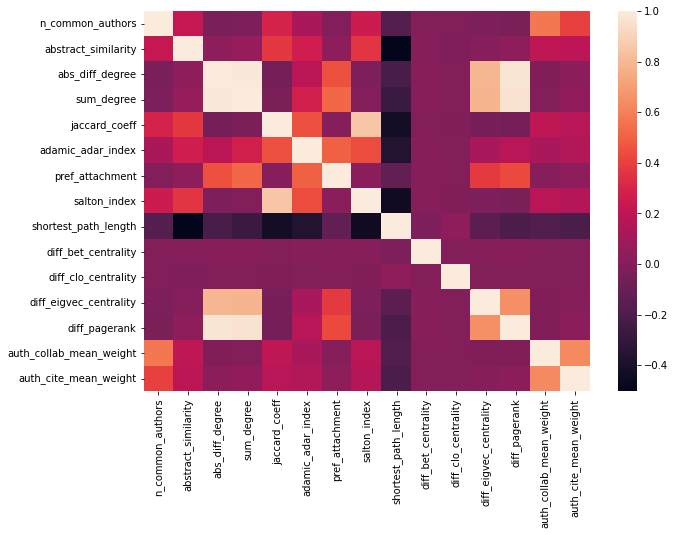

In [8]:
sns.heatmap(X_train.corr())
plt.show()

## 2. Add cosine similarity of node embeddings

Since we have the node/paper embeddings, we have to compute a link feature because our datasets contain link (pairs of nodes). We define the following operator to do so

In [9]:
feature_names = list(X_train.columns) + ['gae_similarity', 'node2vec_similarity']

In [10]:
def cosine_similarity(u, v):
  return (u @ v.T) / (np.linalg.norm(u) * np.linalg.norm(v))

In [11]:
def get_node_embedding(node, node_vectors, mode):
    """Get the embedding of a node from node2vec / gae model."""

    if mode == 'node2vec':
      return node_vectors[str(node)]
    if mode == 'gae':
      return node_vectors[node,:]


def link_feature_from_emb(
    link_examples, node_vectors, mode, binary_operator=cosine_similarity):
    """Compute cosine similarity for the embeddings of node pairs """
    
    return [
        binary_operator(
            get_node_embedding(node_1, node_vectors, mode),
            get_node_embedding(node_2, node_vectors, mode)
        )
        for node_1, node_2 in link_examples
    ]


In [12]:
X_train_gae_similarity = link_feature_from_emb(
    train_pairs.to_numpy(),
    gae_emb_train,
    mode='gae',
)
X_train_node2vec_similarity = link_feature_from_emb(
    train_pairs.to_numpy(),
    node2vec_train,
    mode='node2vec',
)

# Add the cosine similarities to the train set
X_train = np.concatenate(
    (
      X_train.to_numpy(),
      np.array(X_train_gae_similarity).reshape(-1,1),
      np.array(X_train_node2vec_similarity).reshape(-1,1)
    ), 
    axis=1
)
print("Shape of X_train:", X_train.shape)

Shape of X_train: (349424, 17)


In [13]:
X_test_gae_similarity = link_feature_from_emb(
    test_pairs.to_numpy(),
    gae_emb_test,
    mode='gae',
)
X_test_node2vec_similarity = link_feature_from_emb(
    test_pairs.to_numpy(),
    node2vec_test,
    mode='node2vec',
)

# Add the cosine similarities to the test set
X_test = np.concatenate(
    (
      X_test.to_numpy(),
      np.array(X_test_gae_similarity).reshape(-1,1),
      np.array(X_test_node2vec_similarity).reshape(-1,1)
    ), 
    axis=1
)
print("Shape of X_test:", X_test.shape)

Shape of X_test: (436782, 17)


In [14]:
X_challenge_gae_similarity = link_feature_from_emb(
    challenge_pairs.to_numpy(),
    gae_emb_full_graph,
    mode='gae',
)
X_challenge_node2vec_similarity = link_feature_from_emb(
    challenge_pairs.to_numpy(),
    node2vec_full_graph,
    mode='node2vec',
)

# Add the cosine similarities to the challenge set
X_challenge = np.concatenate(
    (
      X_challenge.to_numpy(),
      np.array(X_challenge_gae_similarity).reshape(-1,1),
      np.array(X_challenge_node2vec_similarity).reshape(-1,1)
    ), 
    axis=1
)
print("Shape of X_challenge:", X_challenge.shape)

Shape of X_challenge: (106692, 17)


## 3. Model

In [15]:
from sklearn.metrics import roc_auc_score, log_loss, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.calibration import CalibratedClassifierCV

from xgboost import XGBClassifier

In [16]:
# Split the train set into train and validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_train, train_target, test_size=0.2, random_state=12
)

# Split the test set into test and calibration set
X_test, X_calib, y_test, y_calib = train_test_split(
    X_test, test_target, test_size=0.5, random_state=12
)

In [17]:
print("Size of the training set:", len(X_train))
print("Size of the validation set:", len(X_val))
print("Size of the test set:", len(X_test))
print("Size of the calibration set:", len(X_calib))


Size of the training set: 279539
Size of the validation set: 69885
Size of the test set: 218391
Size of the calibration set: 218391


In [18]:
# X_final_c = np.concatenate((X_train_c, X_test_c1))
# y_final = np.concatenate((train_target, y_test))

In [19]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)

X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_calib = scaler.transform(X_calib)
X_challenge = scaler.transform(X_challenge)

### 3.1. Hyper parameter tuning

In [20]:
# NOTE : Takes 3 mins with GPU

xgb_clf = XGBClassifier(objective='binary:logistic', tree_method="gpu_hist",
                    silent=True)

# A parameter grid for XGBoost
params = {
        'n_estimators' : [100, 300, 600, 1000],
        'learning_rate': [0.01, 0.1, 0.001],
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [4, 5, 6, 8]
}

random_cfl = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=params,
    scoring='neg_log_loss',
    n_iter=20,
    verbose=10,
    n_jobs=-1
)

random_cfl.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:12:00] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:12:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False, gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None...
                                           subsample=None,
                                           tree_method='gpu_hist',
                                           validate_parameters=None,
      

### 3.2. Training the best estimator

In [21]:
best_clf = random_cfl.best_estimator_
best_clf

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              enable_categorical=False, gamma=0.5, gpu_id=0,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=300, n_jobs=2, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              silent=True, subsample=1.0, tree_method='gpu_hist',
              validate_parameters=1, verbosity=None)

In [22]:
eval_set = [(X_train, y_train), (X_val, y_val)]

best_clf.fit(X_train, y_train,
    eval_metric="logloss", eval_set=eval_set, verbose=50,
    early_stopping_rounds=10)

[05:12:01] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.61580	validation_1-logloss:0.61584


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[50]	validation_0-logloss:0.11379	validation_1-logloss:0.11662
[100]	validation_0-logloss:0.10709	validation_1-logloss:0.11141
[150]	validation_0-logloss:0.10513	validation_1-logloss:0.11042
[200]	validation_0-logloss:0.10371	validation_1-logloss:0.10988
[243]	validation_0-logloss:0.10274	validation_1-logloss:0.10965


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              enable_categorical=False, gamma=0.5, gpu_id=0,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=300, n_jobs=2, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              silent=True, subsample=1.0, tree_method='gpu_hist',
              validate_parameters=1, verbosity=None)

### 3.3. Calibration

In [23]:
calibrated_clf = CalibratedClassifierCV(
     base_estimator=best_clf,
     cv="prefit",
     method="isotonic",
     n_jobs=-1
 )

calibrated_clf.fit(X_calib, y_calib)

CalibratedClassifierCV(base_estimator=XGBClassifier(base_score=0.5,
                                                    booster='gbtree',
                                                    colsample_bylevel=1,
                                                    colsample_bynode=1,
                                                    colsample_bytree=0.8,
                                                    enable_categorical=False,
                                                    gamma=0.5, gpu_id=0,
                                                    importance_type=None,
                                                    interaction_constraints='',
                                                    learning_rate=0.1,
                                                    max_delta_step=0,
                                                    max_depth=4,
                                                    min_child_weight=1,
                                                    missing=

### 3.4. Evaluation on the test set

In [24]:
xgb_pred_prob = best_clf.predict_proba(X_test)[:,1]
xgb_pred = best_clf.predict(X_test)

calibrated_pred_prob = calibrated_clf.predict_proba(X_test)[:,1]
calibrated_pred = calibrated_clf.predict(X_test)

In [25]:
print("Before calibration")

xgb_logloss = log_loss(y_test, xgb_pred_prob)
print(f"log loss: {xgb_logloss:.3f}")

xgb_auc = roc_auc_score(y_test, xgb_pred_prob)
print(f"AUC score: {xgb_auc:.3f}")

xgb_f1 = f1_score(y_test, xgb_pred)
print(f"F1 score: {xgb_f1:.3f}")

print('-' * 100)
print("After calibration")

calibrated_logloss = log_loss(y_test, calibrated_pred_prob)
print(f"log loss: {calibrated_logloss:.3f}")

calibrated_auc = roc_auc_score(y_test, calibrated_pred_prob)
print(f"AUC score: {calibrated_auc:.3f}")

calibrated_f1 = f1_score(y_test, xgb_pred)
print(f"F1 score: {calibrated_f1:.3f}")


Before calibration
log loss: 0.102
AUC score: 0.993
F1 score: 0.963
----------------------------------------------------------------------------------------------------
After calibration
log loss: 0.099
AUC score: 0.993
F1 score: 0.963


### 3.5 Analysis of the model

#### Feature importance

In [26]:
feat_importance = pd.Series(
    data=best_clf.feature_importances_,
    index=feature_names,
).sort_values(ascending=False)

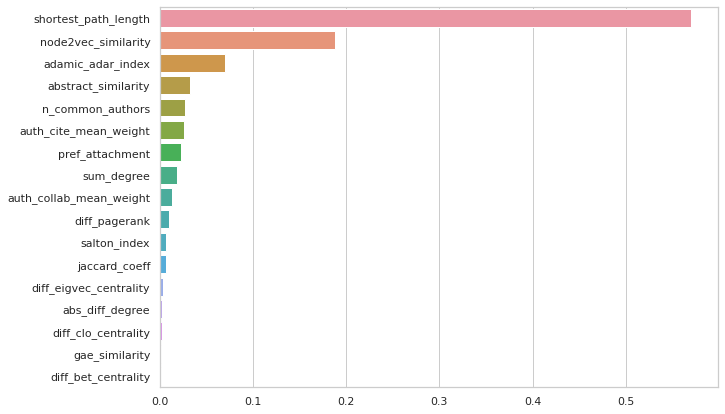

In [35]:
sns.set_theme(style="whitegrid")
sns.barplot(x=feat_importance, y=feat_importance.index)
plt.show()

#### Shap values 

In [2]:
# # UNCOMMENT if using collab
# !pip install shap

In [29]:
import shap

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


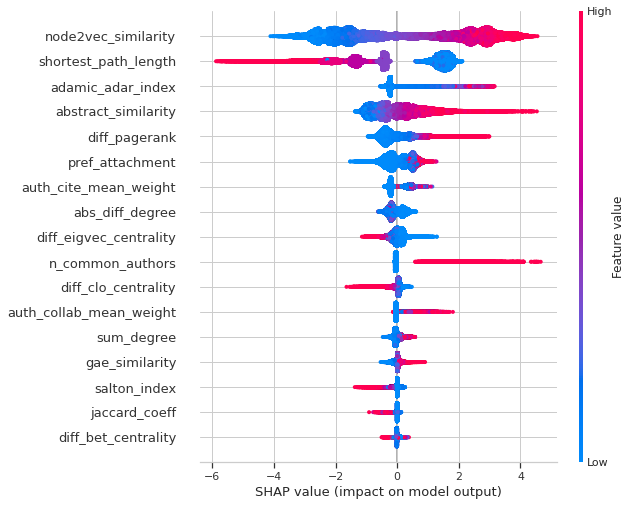

In [33]:
#load JS vis in the notebook
shap.initjs() 

#set the tree explainer as the model of the pipeline
explainer = shap.TreeExplainer(best_clf)

#apply the preprocessing to x_test
observations = pd.DataFrame(X_test, columns=feature_names)

#get Shap values from preprocessed data
shap_values = explainer.shap_values(observations)

#plot the feature importance
shap.summary_plot(shap_values, observations)

### 4. Submission

In [34]:
import csv
y_pred = calibrated_clf.predict_proba(X_challenge)
y_pred = y_pred[:,1]

# Write predictions to a file
predictions = zip(range(len(y_pred)), y_pred)
with open("sub_final_model.csv","w") as pred:
    csv_out = csv.writer(pred)
    csv_out.writerow(['id','predicted'])
    for row in predictions:
        csv_out.writerow(row) 